In [1]:
import numpy as np
import pandas as pd
from scipy.interpolate import interp1d
from scipy.stats import hypergeom, beta, norm
from scipy.optimize import curve_fit
from sklearn.model_selection import train_test_split
from xgboost import XGBRegressor
import random
import matplotlib.pyplot as plt

In [2]:
def quality(N=1000, n=15, k=10, P_threshold_factor = 10, plot = True):
    K = np.array(range(k, N+1))
    P = hypergeom.pmf(k, N, K, n)
    P_threshold = P.max() / P_threshold_factor
    idx = np.where(P >= P_threshold)[0]

    if plot:
        fig = plt.figure(1)
        fig.set_size_inches(10, 5)
        ax = fig.add_subplot(111)
        ax.plot(K/N, P, color='b', ls='-', marker='')
        ax.set_xlabel('K/N')
        ax.set_ylabel('$P|_{k=%d}$' % k)
        ax.set_title('Hypergeometric PMF')
        ax.axhline(P_threshold, color='r', ls='--')
        ax.vlines([K[idx[0]]/N, K[idx[-1]]/N], [0,0], [P.max(), P.max()], color='k', ls='--', lw=2)
        ax.set_title('n=%d, k=%d, Kmin=%.2f, Kmax=%.2f' % (n, k, K[idx[0]]/N, K[idx[-1]]/N))
        plt.grid()
        plt.show()
    return np.array([K[idx[0]]/N, K[idx[-1]]/N])

def cdf_model(x, params, kind):
    if kind == 'normal':
        return 1 - norm.cdf(x, loc=params[0], scale=params[1])
    elif kind == 'beta':
        return 1 - beta.cdf(x, params[0], params[1])
    else:
        print('cdf model error: kind should be "normal" or "beta"')

def pdf_model(x, params, kind):
    if kind == 'normal':
        return norm.pdf(x, loc=params[0], scale=params[1])
    elif kind == 'beta':
        return beta.pdf(x, params[0], params[1])
    else:
        print('pdf model error: kind should be "normal" or "beta"')

def rvs(params, size, kind):
    if kind == 'normal':
        return norm.rvs(loc=params[0], scale=params[1], size = size)
    elif kind == 'beta':
        return beta.rvs(a=params[0], b=params[1], size=size)
    else:
        print('rvs error: kind should be "normal" or "beta"')

def params_bounds(kind):
    if kind == 'normal':
        return ([1e-3, 1-1e-3], [1e-3, 1/6])
    elif kind == 'beta':
        return ([1, 5], [1, 5])
    else:
        print('params lim error: kind should be "normal" or "beta"')

def init_guess(kind):
    if kind == 'normal':
        return [0.5, 1/6]
    elif kind == 'beta':
        return [1.1, 1.1]
    else:
        print('init guess error: kind should be "normal" or "beta"')

def rmse(y_true, y_pred):
    for col in range(y_true.shape[1]):
        r = np.sqrt(np.mean((y_true[:, col] - y_pred[:, col])**2))
        print('RMSE for column %d: %.4f' % (col, r))

def mae(y_true, y_pred):
    for col in range(y_true.shape[1]):
        r = np.mean(np.abs(y_true[:, col] - y_pred[:, col]))
        print('MAE for column %d: %.4f' % (col, r))

In [3]:
kind = 'normal'

n = 10
samples = np.zeros(n+2, dtype=float)
samples[-1] = 1.0

K = np.array(list(map(lambda x: quality(N = n*100, n = n, k = x, P_threshold_factor=10, plot=False), range(n, 0, -1))))
Kmin = np.append(np.append([1.0], K[:, 0]), [0.0])
Kmax = np.append(np.append([1.0], K[:, 1]), [0.0])

x = np.linspace(0, 1, 101)
p1_n, p2_n , n_0 = 15, 15, 500

iter_num = p1_n * p2_n * n_0
print('iter_num = %d' % iter_num)

iter_num = 112500


In [4]:
# Interpolation
p1 = np.zeros(iter_num)
p2 = np.zeros(iter_num)

x1 = np.zeros((iter_num, x.size))
x2 = np.zeros((iter_num, x.size))

sampling_params = np.zeros((iter_num, 2))

p1_bounds, p2_bounds = params_bounds(kind)
i = -1
for a in np.linspace(p1_bounds[0], p1_bounds[1], p1_n):
    for b in np.linspace(p2_bounds[0], p2_bounds[1], p2_n):
        for j in range(n_0):
            i += 1
            p1[i] = a
            p2[i] = b
            samples[1:-1] = np.sort(rvs([a, b], size = n, kind=kind))
            mean = np.mean(samples[1:-1])
            std = np.std(samples[1:-1], ddof=1)
            var = std**2
            if kind == 'normal':
                sampling_params[i] = [mean, std]
            elif kind == 'beta':
                coeff = mean * (1 - mean) / var - 1
                sampling_params[i,0] = coeff * mean
                sampling_params[i,1] = coeff * (1 - mean)            
            x1[i,:] = interp1d(samples, Kmin, kind='linear')(x)
            x2[i,:] = interp1d(samples, Kmax, kind='linear')(x)
x1 = np.array(x1)
x2 = np.array(x2)
y = np.vstack((p1, p2)).T

In [5]:
# Fitting
from scipy.optimize import minimize
def loss_min(params):
    return np.mean((x1[i] - cdf_model(x, params, kind))**2)
def loss_max(params):
    return np.mean((x2[i] - cdf_model(x, params, kind))**2)

bounds = np.array([np.array(params_bounds(kind)).T[0] * 0.5, np.array(params_bounds(kind)).T[1] * 1.5]).T

xf = np.zeros((iter_num, 4))
for i in range(iter_num):
    xf[i,:2] = minimize(loss_min, init_guess(kind), method='Nelder-Mead', bounds=bounds).x
    xf[i,2:] = minimize(loss_max, init_guess(kind), method='Nelder-Mead', bounds=bounds).x


In [6]:
# Modeling
x_train, x_test, y_train, y_test, _, x1_test, _, x2_test, _, xc_test = \
    train_test_split(xf, y, x1, x2, sampling_params, test_size=0.3, random_state=15)
xgb = XGBRegressor(objective='reg:squarederror', 
                   colsample_bytree=0.1,
                   learning_rate=0.2,
                   max_depth=15,
                   n_estimators=200,
                   booster="gbtree",
                   eval_metric="rmse",
                   subsample=1.0,
                   reg_alpha=0.0,
                   reg_lambda=0.0,
                   random_state=123,
                   eta=0.1,
                   gamma=0.0
                  )
xgb.fit(x_train, y_train)
y_pred = xgb.predict(x_test)
rmse(y_test, y_pred)

RMSE for column 0: 0.0337
RMSE for column 1: 0.0261


i = 26258


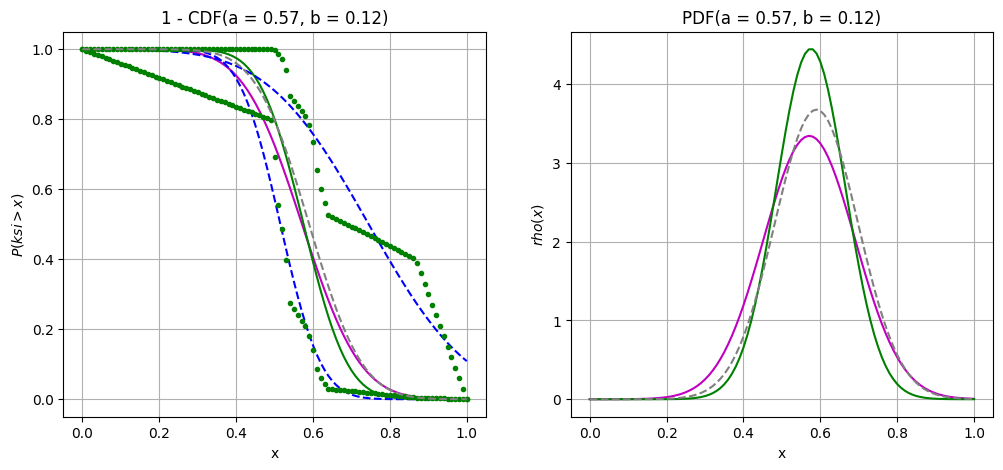

In [7]:
i = random.randint(0, y_test.shape[0]-1)
print('i = %d' % i)

fig = plt.figure(1)
fig.set_size_inches(12, 5)
ax = fig.add_subplot(121)
ax.plot(x, cdf_model(x, y_test[i], kind), color='m', ls='-', marker='')
ax.plot(x, cdf_model(x, y_pred[i], kind), color='g', ls='-', marker='')
ax.plot(x, cdf_model(x, x_test[i,:2], kind), color='b', ls='--', marker='')
ax.plot(x, cdf_model(x, x_test[i,2:], kind), color='b', ls='--', marker='')

ax.plot(x, x1_test[i], color='g', ls='none', marker='.')
ax.plot(x, x2_test[i], color='g', ls='none', marker='.')

ax.plot(x, cdf_model(x, xc_test[i], kind), color='gray', ls='--', marker='')


ax.set_xlabel('x')
ax.set_ylabel('$P(ksi > x)$')
ax.set_title('1 - CDF(a = %.2f, b = %.2f)' % (y_test[i, 0], y_test[i, 1]))
ax.grid()

ax = fig.add_subplot(122)
ax.plot(x, pdf_model(x, y_test[i], kind), color='m', ls='-', marker='')
ax.plot(x, pdf_model(x, y_pred[i], kind), color='g', ls='-', marker='')
ax.plot(x, pdf_model(x, xc_test[i], kind), color='gray', ls='--', marker='')
ax.set_xlabel('x')
ax.set_ylabel('$rho(x)$')
ax.set_title('PDF(a = %.2f, b = %.2f)' % (y_test[i, 0], y_test[i, 1]))
ax.grid()
plt.show()

In [8]:
# How predicted distribution better than normal distribution with sampling mean and std?
print(n)

rmse(y_test, xc_test)
rmse(y_test, y_pred)

mae(y_test, xc_test)
mae(y_test, y_pred)


10
RMSE for column 0: 0.0312
RMSE for column 1: 0.0231
RMSE for column 0: 0.0337
RMSE for column 1: 0.0261
MAE for column 0: 0.0213
MAE for column 1: 0.0158
MAE for column 0: 0.0231
MAE for column 1: 0.0198


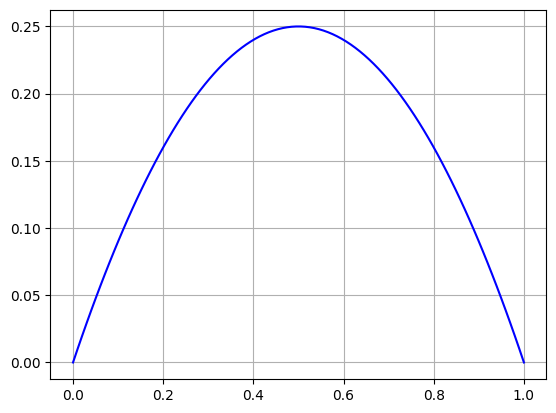

In [5]:
mu = np.linspace(0, 1, 100)
s2 = mu * (1 - mu)

plt.plot(mu, s2, color='b', ls='-', marker='')
plt.grid()

In [6]:
mu = 0.18
s2 = mu * (1 - mu)
s2


0.1476